In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from tokenizers import AddedToken
from datasets import Dataset, features

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold

C:\Users\ctiha\Desktop\atmacup\atmaCup_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("data/train.csv")#.head(1000)
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/atmaCup17__sample_submission.csv")

In [3]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 1
    MODEL_PATH = "microsoft/deberta-v3-large"
    MAX_LENGTH = 256
    STEPS = 25
    USE_GPU = torch.cuda.is_available()
    SEED = 0
    N_SPLIT = 3
    target_col = 'Recommended IND'
    target_col_class_num = 2
    metric = 'auc'
    metric_maximize_flag = True

In [4]:
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if CFG.USE_GPU:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(CFG.SEED)
device = torch.device('cuda' if CFG.USE_GPU else 'cpu')

- Clothing ID: 衣服のID
- Age: レビューをしている人の年齢
- Title: レビューのタイトル
- Review Text: レビューの本文
- Rating: レビューでつけた点数。この列は学習用データでのみ提供されます。
- Recommended IND: レビューした人が、この商品をおすすめするかどうか。今回のコンペではこの値が1になる確率を予測してください。学習用データでのみ提供されます。
- Positive Feedback Count: 他のユーザーからつけられたイイネの数。

In [5]:
train

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,25,3-season skirt!,"Adorable, well-made skirt! lined and very slim...",5,1,4
1,0,39,Very cute,Love the asymmetrical hem. waist fit snugly as...,5,1,0
2,0,42,Beautiful! fruns small for typical retailer si...,I love this skirt! i wasn't sure about the mix...,5,1,5
3,0,45,NaN,I was really pleased with this skirt. the ligh...,5,1,9
4,0,57,"Unique, pretty asymmetric skirt",I saw this skirt in retailer several months ag...,5,1,1
...,...,...,...,...,...,...,...
9995,232,57,Runs big on top,NaN,3,1,5
9996,232,58,NaN,"I loved the dress, but just not dressy enough ...",1,1,5
9997,232,60,I was really disappointed,I was really hoping this dress would work beca...,2,0,7
9998,232,62,Too heavy,The design is beautiful but it was thick and t...,2,0,0


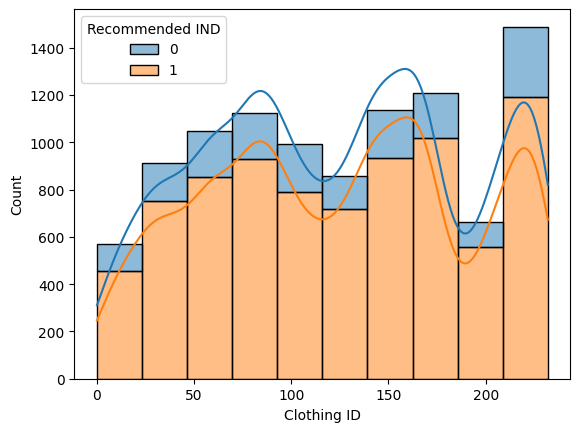

In [6]:
sns.histplot(data=train, x=train["Clothing ID"], hue='Recommended IND', bins=10, kde=True, multiple='stack')
plt.show()

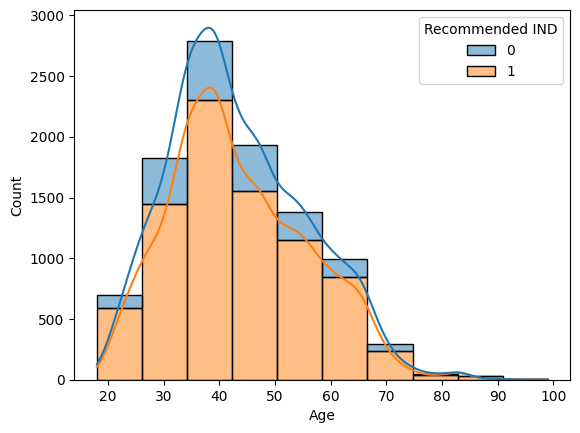

In [7]:
sns.histplot(data=train, x=train["Age"], hue='Recommended IND', bins=10, kde=True, multiple='stack')
plt.show()

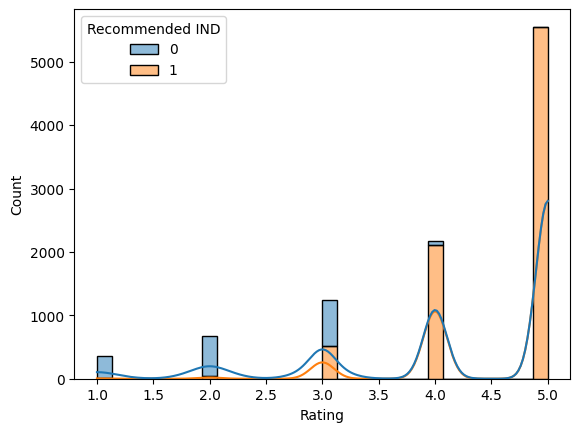

In [8]:
sns.histplot(data=train, x=train["Rating"], hue='Recommended IND', bins=30, kde=True, multiple='stack')
plt.show()

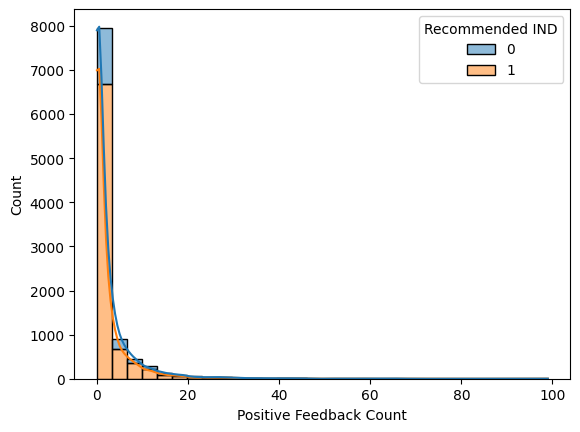

In [9]:
sns.histplot(data=train, x=train["Positive Feedback Count"], hue='Recommended IND', bins=30, kde=True, multiple='stack')
plt.show()

In [10]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

C:\Users\ctiha\Desktop\atmacup\atmaCup_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\ctiha\Desktop\atmacup\atmaCup_env\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialize

In [11]:
train["text"] = train["Title"].fillna("") + " " + train["Review Text"].fillna("")
test["text"] = test["Title"].fillna("") + " " + test["Review Text"].fillna("")

In [12]:
train_texts = train["text"].values.tolist()
train_labels = train["Recommended IND"].values.tolist()

test_texts = test["text"].values.tolist()



def generate_random_binary_list(length):
    # 指定した長さのランダムな0と1のリストを生成
    random_binary_list = [random.randint(0, 1) for _ in range(length)]
    return random_binary_list
test_labels = generate_random_binary_list(len(test_texts))

In [13]:
# データセットの分割
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2)

# テキストとラベルを含む辞書を作成
train_data = {'text': train_texts, 'label': train_labels}
valid_data = {'text': valid_texts, 'label': valid_labels}
test_data = {'text': test_texts, 'label': test_labels}

# Hugging Faceのデータセットに変換
train_dataset = Dataset.from_dict(train_data)
valid_dataset = Dataset.from_dict(valid_data)
valid_dataset = Dataset.from_dict(test_data)

In [14]:
# metricをAUCに変更
def compute_metrics(p):
    preds, labels = p
    preds = torch.softmax(torch.tensor(preds), dim = 1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {'auc': score}

In [15]:
# トークナイザーを使ってデータセットをトークン化
def tokenize_function(example):
    return tokenizer(example['text'], padding="max_length", truncation=True, max_length=128)

predictions = np.zeros((len(train), 2))

# ラベルが均一になるようにCV
#kfold = StratifiedKFold(n_splits = CFG.N_SPLIT, shuffle = True, random_state = CFG.SEED)
#for fold, (train_index, valid_index) in enumerate(kfold.split(train_df, train_df['Rating'])):
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

#ds_train = Dataset.from_pandas(train_df.iloc[train_index][['prompt', 'labels']].copy())
#ds_eval = Dataset.from_pandas(train_df.iloc[valid_index][['prompt', 'labels']].copy())


# トレーニングパラメータの設定
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    fp16=True,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,  # 最も良いモデルをトレーニング終了時にロード
    metric_for_best_model="auc",  # 評価指標としてロスを使用
    save_strategy="epoch",  # エポックごとにモデルを保存
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)



# Trainerの作成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,  # 評価指標を計算する関数を指定

)

# モデルのトレーニング
trainer.train()

Map: 100%|████████████████████████████████████████████████████████████| 11155/11155 [00:01<00:00, 10384.77 examples/s]
C:\Users\ctiha\Desktop\atmacup\atmaCup_env\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Auc
1,0.199400,2.738014,0.500815
2,0.212200,2.592277,0.499397
3,0.140700,2.737026,0.499375
4,0.156000,3.554629,0.501457


KeyboardInterrupt: 

In [ ]:
# モデルの評価
eval_result = trainer.evaluate()

# 評価結果を表示
print(f"Evaluation results: {eval_result}")


In [ ]:
# 推論
predictions = trainer.predict(test_dataset)
# ロジットを取得し、シグモイド関数で確率に変換
logits = predictions.predictions
probs = torch.sigmoid(torch.tensor(logits))
sample_submission["target"] = probs[:,1]

In [ ]:
sample_submission.to_csv("output/baseline3.csv",index=False)